## State Schema

- Pydanticを使って状態を定義するのが一番いい

### TypedDictを使って状態を定義する

In [1]:
# TypedDict
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

In [2]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy", "sad"]

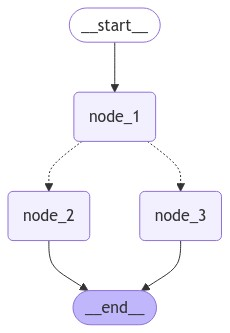

In [3]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


def node_1(state):
    print("--- Node 1 ---")
    return {"name": state["name"] + "は"}

def node_2(state):
    print("--- Node 2 ---")
    return {"mood": "幸せです！"}

def node_3(state):
    print("--- Node 3 ---")
    return {"mood": "悲しいです！"}

def decide_mood(state) -> Literal["node_2", "node_3"]:
    if random.random() < 0.5:
        return "node_2"
    
    return "node_3"

builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"name": "Lance"})

--- Node 1 ---
--- Node 2 ---


{'name': 'Lanceは', 'mood': '幸せです！'}

### Dataclassを使って状態を定義する

In [6]:
# Dataclassを使った状態の定義
# TypedDictとちがって state.name のようにアクセスできる
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy", "sad"]

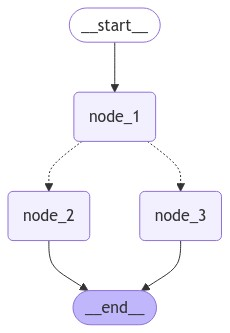

In [9]:
def node_1(state):
    print("--- Node 1 ---")
    # state.nameで状態のプロパティにアクセスできる
    return {"name": state.name + "は"}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# 初期状態もdictではなくDataclassStateのインスタンスで渡す
graph.invoke(DataclassState(name="Lance", mood="sad"))

--- Node 1 ---
--- Node 2 ---


{'name': 'Lanceは', 'mood': '幸せです！'}

In [14]:
# Dataclassの欠点として実行時の型チェックがない
# happy or sad以外を渡してもエラーにならない
dataclass_instance = DataclassState(name="Lance", mood="mad")
graph.invoke(dataclass_instance)

--- Node 1 ---
--- Node 2 ---


{'name': 'Lanceは', 'mood': '幸せです！'}

### Pydanticを使って状態を定義する

In [16]:
# Pydanticを使った状態の定義
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str  # happy or sad

    @field_validator("mood")
    @classmethod
    def validate_mood(cls, value):
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either happy or sad")
        return value

try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either happy or sad [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error


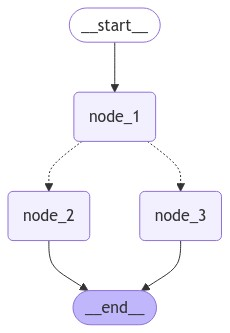

In [17]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
graph.invoke(PydanticState(name="Lance", mood="sad"))

--- Node 1 ---
--- Node 2 ---


{'name': 'Lanceは', 'mood': '幸せです！'}

In [20]:
try:
    graph.invoke(PydanticState(name="Lance", mood="mad"))
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either happy or sad [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error


## State Reducers

### デフォルトでは状態は上書きされる

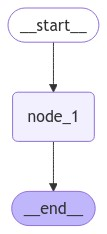

In [21]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int


def node_1(state):
    print("--- Node 1 ---")
    return {"foo": state["foo"] + 1}


builder = StateGraph(State)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
graph.invoke({"foo": 1})

--- Node 1 ---


{'foo': 2}

### 並列に動く枝分かれがあるケース

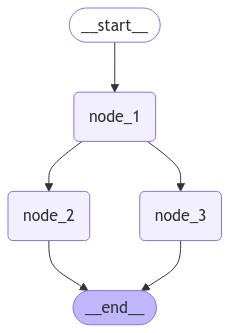

In [24]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("--- Node 1 ---")
    return {"foo": state["foo"] + 1}

def node_2(state):
    print("--- Node 2 ---")
    return {"foo": state["foo"] + 1}

def node_3(state):
    print("--- Node 3 ---")
    return {"foo": state["foo"] + 1}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")

# ノード2とノード3は並列に動く
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")

builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
from langgraph.errors import InvalidUpdateError

# 並列に動作するノード2とノード3が同時に状態fooを上書きしようとしたためエラーになる
try:
    graph.invoke({"fool": 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

InvalidUpdateError occurred: Must write to at least one of ['foo']


### Reducers

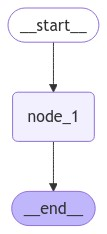

In [41]:
from operator import add
from typing import Annotated

class State(TypedDict):
    # addはリストのconcatをする
    foo: Annotated[list[int], add]

def node_1(state):
    print("--- Node 1 ---")
    return {"foo": [state["foo"][0] + 1]}

builder = StateGraph(State)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")

builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
add([1], [2])

[1, 2]

In [40]:
graph.invoke({"foo": [1]})

--- Node 1 ---


{'foo': [1, 2]}

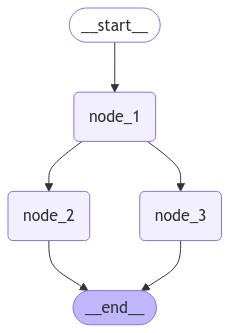

In [44]:
def node_1(state):
    print("--- Node 1 ---")
    return {"foo": [state["foo"][-1] + 1]}

def node_2(state):
    print("--- Node 2 ---")
    return {"foo": [state["foo"][-1] + 1]}

def node_3(state):
    print("--- Node 3 ---")
    return {"foo": [state["foo"][-1] + 1]}

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")

# ノード2とノード3は並列に動く
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")

builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
# node_1によって2が追加される
# node_2とnode_3によってそれぞれ3が追加される
graph.invoke({"foo": [1]})

--- Node 1 ---
--- Node 2 ---
--- Node 3 ---


{'foo': [1, 2, 3, 3]}

In [48]:
# Noneを与えるとリストのconcatがaddでできずにエラーになる
try:
    graph.invoke({"foo": None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


### Noneがきても大丈夫なカスタムReducersを作る

In [51]:
def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right


class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

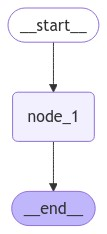

TypeError occurred: can only concatenate list (not "NoneType") to list


In [57]:
def node_1(state):
    print("--- Node 1 ---")
    # 2を追加
    return {"foo": [2]}

builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")

builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo": None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

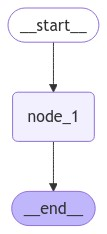

--- Node 1 ---
{'foo': [2]}


In [56]:
def node_1(state):
    print("--- Node 1 ---")
    # 2を追加
    return {"foo": [2]}

builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")

builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo": None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## 過去のメッセージの要約処理

In [2]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

In [5]:
from langgraph.graph import MessagesState

class State(MessagesState):
    # messagesはデフォルトで含まれる
    summary: str

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage


def call_model(state: State):
    summary = state.get("summary", "")

    # 要約があったらシステムプロンプトに追加
    if summary:
        system_message = f"以前の会話の要約: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [8]:
def summarize_conversation(state: State):
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"これまでの会話の要約は以下の通りです: {summary}\n\n"
            "上記の新しいメッセージを考慮して要約を更新してください:"
        )
    else:
        summary_message = "上記の会話の要約を作成してください:"
    
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # 最新の2つの会話を残して残りを削除する
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [9]:
from langgraph.graph import END


def should_continue(state: State):
    messages = state["messages"]

    # メッセージが増えたら要約を作成する
    if len(messages) > 6:
        return "summarize_conversation"

    return END

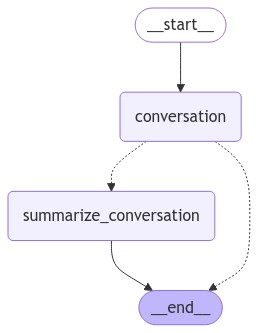

In [14]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": "1"}}

input_message = HumanMessage(content="こんにちは。私はLanceです。")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

こんにちは。私はLanceです。
================================== Ai Message ==================================

こんにちは、Lanceさん！お元気ですか？何かお手伝いできることがあれば教えてください。


In [16]:
input_message = HumanMessage(content="私の名前はなに？")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

こんにちは。私はLanceです。
================================== Ai Message ==================================

こんにちは、Lanceさん！お元気ですか？何かお手伝いできることがあれば教えてください。
================================ Human Message =================================

私の名前はなに？
================================== Ai Message ==================================

あなたの名前はLanceです。何か他にお話ししたいことがありますか？


In [17]:
input_message = HumanMessage(content="私は49ersのファンです。")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

こんにちは。私はLanceです。
================================== Ai Message ==================================

こんにちは、Lanceさん！お元気ですか？何かお手伝いできることがあれば教えてください。
================================ Human Message =================================

私の名前はなに？
================================== Ai Message ==================================

あなたの名前はLanceです。何か他にお話ししたいことがありますか？
================================ Human Message =================================

私は49ersのファンです。
================================== Ai Message ==================================

49ersのファンなんですね！サンフランシスコ・49ersはNFLの伝統的なチームで、多くの素晴らしい選手や歴史がありますね。好きな選手や思い出の試合などありますか？


In [19]:
graph.get_state(config).values.get("summary", "")

''

In [20]:
input_message = HumanMessage(content="私はNick Bosaが好きです。")
output = graph.invoke({"messages": [input_message]}, config)
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

私はNick Bosaが好きです。
================================== Ai Message ==================================

Nick Bosaは素晴らしい選手ですね！彼のパスラッシュ能力やディフェンスでの存在感は本当に印象的です。特に彼のルーキーシーズンや、最近のシーズンでの活躍は多くのファンを魅了しています。彼のプレーで特に好きな瞬間や試合はありますか？


In [22]:
print(graph.get_state(config).values.get("summary", ""))

Lanceさんはサンフランシスコ・49ersのファンで、特に選手のNick Bosaが好きだと話しました。Bosaのパスラッシュ能力やディフェンスでの存在感について言及し、彼の活躍が多くのファンを魅了していることを共有しました。
